In [1]:
import numpy as np
import json
import thulac
import re
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tqdm import tqdm
import cv2 as cv
import os
import glob

In [ ]:
data = np.load('data/data.npy')
labels = np.load('data/labels.npy')

In [3]:
# 为了提高识别的准确率，对数据集进行打乱处理
permutation = np.random.permutation(labels.shape[0])
data = data[permutation, :]
labels = labels[permutation]

In [4]:
#构建RNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(int(data.max() + 1),output_dim=64),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [5]:
# 定义优化器
adam = keras.optimizers.Adam(0.0001)

In [6]:
model.compile(optimizer=adam, 
              metrics=['acc'],
              loss='binary_crossentropy')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          3180864   
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 3,197,761
Trainable params: 3,197,761
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 使用 Tensorboard 作为模型训练监视器，监控过拟合
tensorBoard = keras.callbacks.TensorBoard(log_dir='kerasLog', write_images=1, histogram_freq=1)

In [9]:
history=model.fit(data, labels, batch_size=64, validation_split=0.3, epochs=20, callbacks=[tensorBoard], verbose=1)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 125s 3ms/sample - loss: 0.7704 - acc: 0.5219 - val_loss: 0.6824 - val_acc: 0.5553
Epoch 2/20
42000/42000 [==============================] - 123s 3ms/sample - loss: 0.6743 - acc: 0.5852 - val_loss: 0.6641 - val_acc: 0.6141
Epoch 3/20
42000/42000 [==============================] - 122s 3ms/sample - loss: 0.6376 - acc: 0.6792 - val_loss: 0.6051 - val_acc: 0.7106
Epoch 4/20
42000/42000 [==============================] - 123s 3ms/sample - loss: 0.5575 - acc: 0.7713 - val_loss: 0.5426 - val_acc: 0.7970
Epoch 5/20
42000/42000 [==============================] - 124s 3ms/sample - loss: 0.5125 - acc: 0.7949 - val_loss: 0.5243 - val_acc: 0.7898
Epoch 6/20
42000/42000 [==============================] - 123s 3ms/sample - loss: 0.4893 - acc: 0.8156 - val_loss: 0.5198 - val_acc: 0.8130
Epoch 7/20
42000/42000 [==============================] - 122s 3ms/sample - loss: 0.4766 - acc: 0.8176 - val_l

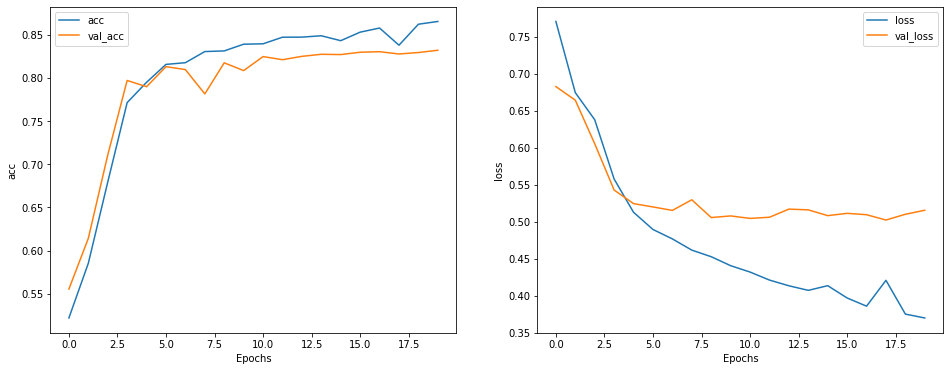

In [10]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [11]:
model.save('model.h5')

In [12]:
model = keras.models.load_model('model.h5')
fin = open('data/word_dict.json', 'r+', encoding='utf8')
word_dict = json.load(fin)
fin.close()

In [13]:
thu = thulac.thulac(seg_only=True, T2S=True, filt=False)
def encodeReview(comment):
    global thu,word_dict

    texts = thu.cut(comment, text=True)
    texts = texts.split(' ')

    encodedReview = np.array([1]) # <START>
    for text in texts:
        if(word_dict.get(text) != None):
            encodedReview = np.append(encodedReview, word_dict[text])
        else:
            encodedReview = np.append(encodedReview, 2) # <UNK>

    return encodedReview

Model loaded succeed


In [14]:
nagativeComment = encodeReview(' 什么破烂反派，毫无戏剧冲突能消耗两个多小时生命，还强加爱情戏。脑残片好圈钱倒是真的。')
activeComment = encodeReview('机甲之战超超好看，比变形金刚强；人，神，变异人，人工智能互殴，强强强强；每一小段末句都是槽或者笑点，应该死了不少编剧；Jane不来客串，雷神没露，扣分；女神配怪兽，fair enough；美国队长我最喜欢他的盾，大概因为紫龙；难得人物多次发表演讲还不死；最后，找到了下半年新发型，开心！')
# 使用 np.expand_dims 在不改变数据值的情况下扩增一个维度
nagativeComment = np.expand_dims(nagativeComment, axis = 0)
activeComment = np.expand_dims(activeComment, axis = 0)

In [15]:
print(nagativeComment)
print('------')
print(activeComment)

[[    1 40792 47520  5091  4340     2   923 16727 47911 27993 16609 40131
  41451 11423 31535  4340 40388 41833  8987 32095 48736 12225  1254 43755
   1472 33614 27202 46804 48736]]
------
[[    1  6156 39099 32975  2715 12350  4340 30163 30727  5503   916 45957
   4340 48882  4340 43078  4230  4340 39775 12948  4340   696  9426  9426
    916 35883 36185 13143  4898 34151  4711 27046 20720 43396  3830  2442
   4340     2 24332 17826     2  5484   916 34875 10819 31580 36739  4340
  20401  7123 27819  4340 41740   916 23791 17324  4340 21273 24796   916
   6333 36095 47474  9089  9979 13406 46804 44944  4340 24119  7740  3353
    916 39589 10969 21958 27462 40388 10819 24332   916 44974  4340 12908
  17826  1840 48529  4340 48673   681]]


In [16]:
nResult = model.predict(nagativeComment)
aResult = model.predict(activeComment)

In [17]:
print(nResult)
if(nResult[0][0] < 0.5):
    print('负面')
else:
    print('正面')

if(aResult[0][0] < 0.5):
    print('负面')
else:
    print('正面')

[[-2.436047]]
负面
正面
